In [1]:
# import table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as ra
import json
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F

from dp_processor import Processor
from dp_wgan import Generator, Discriminator
from dp_autoencoder import Autoencoder
import dp_optimizer, sampling, analysis

from pm4py.objects.log.importer.xes import importer
from pm4py.algo.filtering.log.variants import variants_filter

from dpv.data_utility import emd_utility, log_diff


# settings
torch.manual_seed(0)
np.random.seed(0)

In [2]:
# import xes event log (Sepsis example)
log = importer.apply('sepsis.xes')

parsing log, completed traces :: 100%|██████████| 1050/1050 [00:00<00:00, 1269.79it/s]


In [3]:
# extract variants
variants = variants_filter.get_variants(log)

# number of variants
len(variants)

846

In [458]:
# create dataframe
var_log = []

for var in variants:
    var_log += [var] * len(variants[var])
    
ra.shuffle(var_log)
df = pd.DataFrame({'variant': var_log})
df_orig = pd.DataFrame({'orig': var_log})
df

,variant
0,"ER Registration,ER Triage,ER Sepsis Triage,IV ..."
1,"Leucocytes,CRP,ER Registration,ER Triage,ER Se..."
2,"ER Registration,ER Triage,ER Sepsis Triage,CRP..."
3,"ER Registration,ER Triage,Leucocytes,LacticAci..."
4,"ER Registration,ER Triage,ER Sepsis Triage,IV ..."
...,...
1045,"ER Registration,ER Triage,ER Sepsis Triage,Leu..."
1046,"ER Registration,ER Triage,ER Sepsis Triage,CRP..."
1047,"ER Registration,LacticAcid,CRP,Leucocytes,ER T..."
1048,"ER Registration,ER Triage,CRP,Leucocytes,ER Se..."


In [459]:
# init data processor
datatypes = [('variant', 'categorical')]
processor = Processor(datatypes)

# encode categories
for column, datatype in datatypes:
    if 'categorical' in datatype:
        df[column] = df[column].astype('category').cat.codes

# init training data
train_df = df.head(int(len(df)*0.99))
train_cutoff = int(len(df)*0.99)

# create tensor data
X_real = torch.tensor(df.values, dtype=torch.float32)
X_encoded = torch.tensor(processor.fit_transform(X_real), dtype=torch.float32)

# create train / test tensors
X_train_real = X_real[:train_cutoff]
X_test_real = X_real[train_cutoff:]

# create encoded train / test tensors
X_train_encoded = X_encoded[:train_cutoff]
X_test_encoded = X_encoded[train_cutoff:]

# print preview
print(X_train_encoded, X_train_encoded.shape)
print(X_test_encoded, X_test_encoded.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) torch.Size([1039, 846])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) torch.Size([11, 846])


In [460]:
# autoencoder config
ae_params = {
    'b1': 0.9,
    'b2': 0.999,
    'binary': True,
    'compress_dim': 128,
    'delta': 1e-2,
    'device': 'cpu',
    'iterations': 20000,
    'lr': 0.005,
    'l2_penalty': 0.,
    'l2_norm_clip': 0.012,
    'minibatch_size': 64,
    'microbatch_size': 1,
    'noise_multiplier': 15,
    'nonprivate': True,
}

# OPTIMIZED HYPERPARAMETER

# 0.01
# 2 : 15, 64, 20000
# 1 : 25, 64, 20000
# 0.1 : 50, 32, 20000
# 0.01: 100, 32, 20000

# 0.001
# 2: 18 64 20k
# 1: 28 64 20k 
# 0.1: 60 32 20k 
# 0.01: 140 64 20k x

# 0.0001
# 2: 19, 64, 20k
# 1: 31, 64, 20k
# 0.1: 70, 32, 20k
# 0.01: 180, 64, 20k x

# -5
# 2: 22 64 20k
# 1: 36 64 20k
# 0.1: 80 32 20k
# 0.01: 220 64 20k x

# -6
# 2: 24 64 20k
# 1: 40 64 20k
# 0.1: 90 32 20k
# 0.01: 270 64 20k x

# init autoencoder
autoencoder = Autoencoder(
    example_dim=len(X_train_encoded[0]),
    compression_dim=ae_params['compress_dim'],
    binary=ae_params['binary'],
    device=ae_params['device'],
)

# init decoding optimizer
decoder_optimizer = dp_optimizer.DPAdam(
    l2_norm_clip=ae_params['l2_norm_clip'],
    noise_multiplier=ae_params['noise_multiplier'],
    minibatch_size=ae_params['minibatch_size'],
    microbatch_size=ae_params['microbatch_size'],
    nonprivate=ae_params['nonprivate'],
    params=autoencoder.get_decoder().parameters(),
    lr=ae_params['lr'],
    betas=(ae_params['b1'], ae_params['b2']),
    weight_decay=ae_params['l2_penalty'],
)

# init encoding optimizer
encoder_optimizer = torch.optim.Adam(
    params=autoencoder.get_encoder().parameters(),
    lr=ae_params['lr'] * ae_params['microbatch_size'] / ae_params['minibatch_size'],
    betas=(ae_params['b1'], ae_params['b2']),
    weight_decay=ae_params['l2_penalty'],
)

In [461]:
"""
weights, ds = [], []
for name, datatype in datatypes:
    if 'categorical' in datatype:
        num_values = len(np.unique(df[name]))
        if num_values == 2:
            weights.append(1.)
            ds.append((datatype, 1))
        else:
            for i in range(num_values):
                weights.append(1. / num_values)
            ds.append((datatype, num_values))
    else:
        weights.append(1.)
        ds.append((datatype, 1))
weights = torch.tensor(weights).to(ae_params['device'])
"""

# define loss
#autoencoder_loss = (lambda input, target: torch.mul(weights, torch.pow(input-target, 2)).sum(dim=1).mean(dim=0))
#autoencoder_loss = lambda input, target: torch.mul(weights, F.binary_cross_entropy(input, target, reduction='none')).sum(dim=1).mean(dim=0)
autoencoder_loss = nn.BCELoss()
#autoencoder_loss = nn.MSELoss()

# print network structure
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=846, out_features=487, bias=True)
    (1): Tanh()
    (2): Linear(in_features=487, out_features=128, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=487, bias=True)
    (1): Tanh()
    (2): Linear(in_features=487, out_features=846, bias=True)
    (3): Sigmoid()
  )
)


In [462]:
# DP parameter analysis
print('Achieves ({}, {})-DP'.format(
    analysis.epsilon(
        len(X_train_encoded),
        ae_params['minibatch_size'],
        ae_params['noise_multiplier'],
        ae_params['iterations'],
        ae_params['delta']
    ),
    ae_params['delta'],
))

Achieves (1.9345919599269208, 0.01)-DP


In [463]:
# init data loader
minibatch_loader, microbatch_loader = sampling.get_data_loaders(
    minibatch_size=ae_params['minibatch_size'],
    microbatch_size=ae_params['microbatch_size'],
    iterations=ae_params['iterations'],
    nonprivate=ae_params['nonprivate'],
)

[Iteration 0/20000] [Loss: 0.695090] [Validation Loss: 0.695103]
[Iteration 1000/20000] [Loss: 0.010698] [Validation Loss: 0.010215]
[Iteration 2000/20000] [Loss: 0.011051] [Validation Loss: 0.010157]
[Iteration 3000/20000] [Loss: 0.010313] [Validation Loss: 0.012496]
[Iteration 4000/20000] [Loss: 0.008207] [Validation Loss: 0.010675]
[Iteration 5000/20000] [Loss: 0.003588] [Validation Loss: 0.009028]
[Iteration 6000/20000] [Loss: 0.002193] [Validation Loss: 0.009422]
[Iteration 7000/20000] [Loss: 0.001277] [Validation Loss: 0.009913]
[Iteration 8000/20000] [Loss: 0.001172] [Validation Loss: 0.010986]
[Iteration 9000/20000] [Loss: 0.000872] [Validation Loss: 0.011375]
[Iteration 10000/20000] [Loss: 0.000872] [Validation Loss: 0.010713]
[Iteration 11000/20000] [Loss: 0.000923] [Validation Loss: 0.010532]
[Iteration 12000/20000] [Loss: 0.000690] [Validation Loss: 0.010793]
[Iteration 13000/20000] [Loss: 0.000626] [Validation Loss: 0.012160]
[Iteration 14000/20000] [Loss: 0.000608] [Valid

<AxesSubplot:>

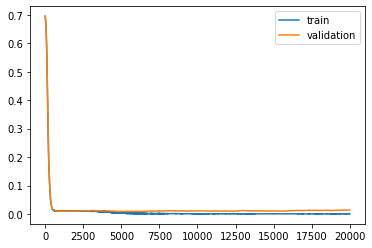

In [464]:
# train autoencoder
train_losses, validation_losses = [], []

X_train_encoded = X_train_encoded.to(ae_params['device'])
X_test_encoded = X_test_encoded.to(ae_params['device'])

for iteration, X_minibatch in enumerate(minibatch_loader(X_train_encoded)):
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    for X_microbatch in microbatch_loader(X_minibatch):

        decoder_optimizer.zero_microbatch_grad()
        output = autoencoder(X_microbatch)
        loss = autoencoder_loss(output, X_microbatch)
        loss.backward()
        decoder_optimizer.microbatch_step()
        
    validation_loss = autoencoder_loss(autoencoder(X_test_encoded).detach(), X_test_encoded)
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    train_losses.append(loss.item())
    validation_losses.append(validation_loss.item())

    if iteration % 1000 == 0:
        print ('[Iteration %d/%d] [Loss: %f] [Validation Loss: %f]' % (
            iteration, ae_params['iterations'], loss.item(), validation_loss.item())
        )

pd.DataFrame(data={'train': train_losses, 'validation': validation_losses}).plot()

In [443]:
# save autoencoder
with open('models/model_sep_ae_0.1_0.000001.dat', 'wb') as f:
    torch.save(autoencoder, f)

In [564]:
# load autoencoder
with open('models/model_sep_ae_2_0.01.dat', 'rb') as f:
    autoencoder = torch.load(f)


In [465]:
# extract decoder
decoder = autoencoder.get_decoder()

In [468]:
# GAN config
gan_params = {
    'alpha': 0.99,
    'binary': True,
    'clip_value': 0.01,
    'd_updates': 15,
    'delta': 1e-2,
    'device': 'cpu',
    'iterations': 1500,
    'latent_dim': 128,
    'lr': 0.005,
    'l2_penalty': 0.,
    'l2_norm_clip': 0.022,
    'minibatch_size': 64,
    'microbatch_size': 1,
    'noise_multiplier':4,
    'nonprivate': False,
}

# OPTIMIZED HYPERPARAMETER

# 0.01 noise minibatch iter
# 2: 4, 64, 1500
# 1: 8, 64, 1500
# 0.1: 28, 64, 1500
# 0.01: 150, 64, 1000

# 0.001
# 2: 5 64 1500
# 1: 10 64 1500
# 0.1: 35 64 1500
# 0.01: 70 128 1000 x

# 0.0001
# 2: 6, 64, 1500
# 1: 11, 64, 1500
# 0.1: 40, 64, 1500
# 0.01: 80, 128, 1000 x

# -5 
# 2: 7 64 1500 
# 1: 12 64 1500
# 0.1: 50 64 1500
# 0.01: 100 128 1000 x

# -6
# 2: 7 64 1500
# 1: 12 64 1500
# 0.1: 50 64 1500
# 0.01: 160 128 1000 x

generator = Generator(
    input_dim=gan_params['latent_dim'],
    output_dim=autoencoder.get_compression_dim(),
    binary=gan_params['binary'],
    device=gan_params['device'],
)

g_optimizer = torch.optim.RMSprop(
    params=generator.parameters(),
    lr=gan_params['lr'],
    alpha=gan_params['alpha'],
    weight_decay=gan_params['l2_penalty'],
)

discriminator = Discriminator(
    input_dim=len(X_train_encoded[0]),
    device=gan_params['device'],
)

d_optimizer = dp_optimizer.DPRMSprop(
    l2_norm_clip=gan_params['l2_norm_clip'],
    noise_multiplier=gan_params['noise_multiplier'],
    minibatch_size=gan_params['minibatch_size'],
    microbatch_size=gan_params['microbatch_size'],
    nonprivate=gan_params['nonprivate'],
    params=discriminator.parameters(),
    lr=gan_params['lr'],
    alpha=gan_params['alpha'],
    weight_decay=gan_params['l2_penalty'],
)

print(generator)
print(discriminator)

Generator(
  (block_0): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=False)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (block_1): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=False)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (block_2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=False)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=846, out_features=564, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=564, out_features=282, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=282, out_features=1, bias=True)
  )
)


In [469]:
# privacy analysis
print('Achieves ({}, {})-DP'.format(
    analysis.epsilon(
        len(X_train_encoded),
        gan_params['minibatch_size'],
        gan_params['noise_multiplier'],
        gan_params['iterations'],
        gan_params['delta']
    ),
    gan_params['delta'],
))

Achieves (2.0388619455149857, 0.01)-DP


In [470]:
# create data loader
minibatch_loader, microbatch_loader = sampling.get_data_loaders(
    minibatch_size=gan_params['minibatch_size'],
    microbatch_size=gan_params['microbatch_size'],
    iterations=gan_params['iterations'],
    nonprivate=gan_params['nonprivate'],
)

[Iteration 0/1500] [D loss: 0.016740] [G loss: -0.004093]


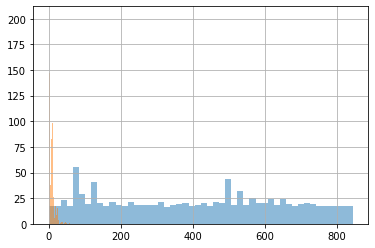

[Iteration 100/1500] [D loss: -0.021555] [G loss: 0.035015]


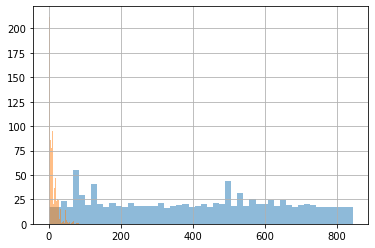

[Iteration 200/1500] [D loss: -0.018946] [G loss: 0.021978]


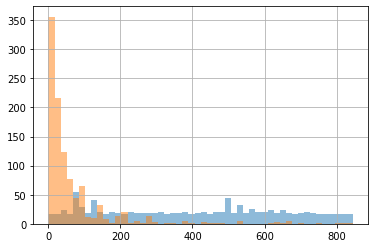

[Iteration 300/1500] [D loss: -0.015086] [G loss: 0.021802]


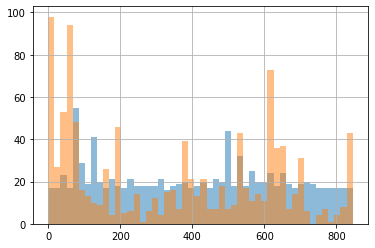

[Iteration 400/1500] [D loss: -0.002191] [G loss: 0.015623]


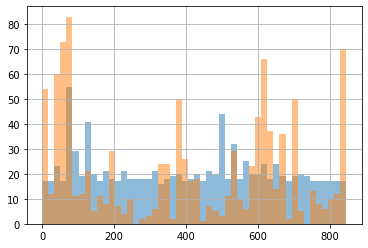

[Iteration 500/1500] [D loss: -0.001958] [G loss: 0.002004]


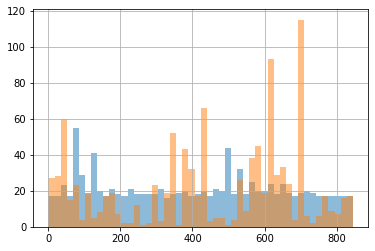

[Iteration 600/1500] [D loss: -0.001381] [G loss: 0.009604]


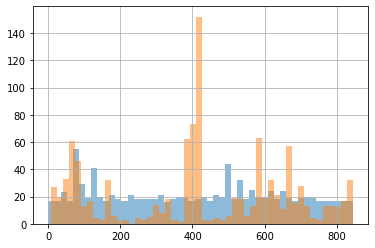

[Iteration 700/1500] [D loss: -0.000512] [G loss: -0.006840]


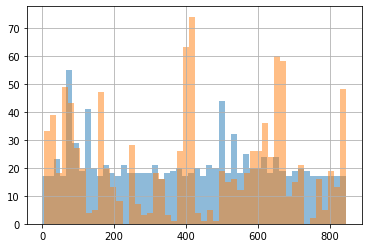

[Iteration 800/1500] [D loss: -0.001316] [G loss: 0.005898]


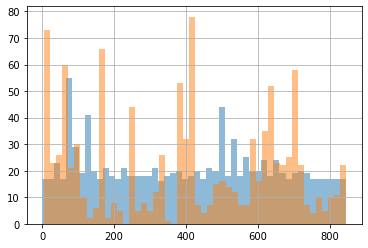

[Iteration 900/1500] [D loss: -0.000378] [G loss: 0.002662]


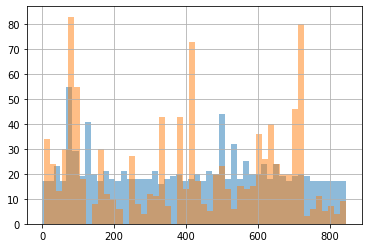

[Iteration 1000/1500] [D loss: -0.000446] [G loss: 0.009502]


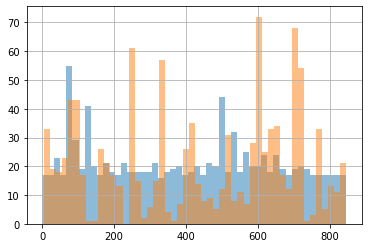

[Iteration 1100/1500] [D loss: -0.000190] [G loss: -0.001595]


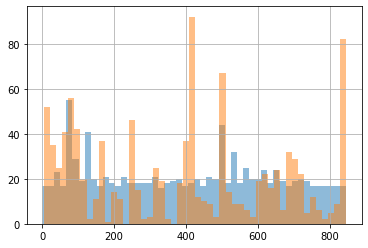

[Iteration 1200/1500] [D loss: -0.000304] [G loss: -0.003660]


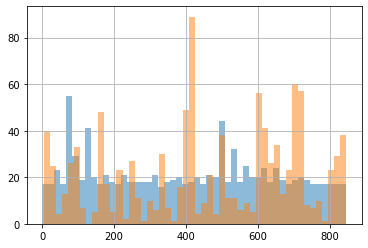

[Iteration 1300/1500] [D loss: 0.000102] [G loss: 0.010528]


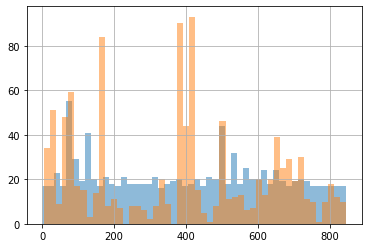

[Iteration 1400/1500] [D loss: -0.000031] [G loss: 0.006146]


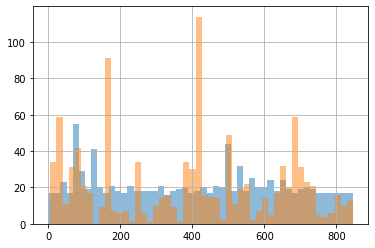

In [471]:
# train GAN
X_train_encoded = X_train_encoded.to(gan_params['device'])
X_test_encoded = X_test_encoded.to(ae_params['device'])

for iteration, X_minibatch in enumerate(minibatch_loader(X_train_encoded)):
    
    d_optimizer.zero_grad()
    
    for real in microbatch_loader(X_minibatch):
        z = torch.randn(real.size(0), gan_params['latent_dim'], device=gan_params['device'])
        fake = decoder(generator(z)).detach()
        
        d_optimizer.zero_microbatch_grad()
        d_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
        d_loss.backward()
        d_optimizer.microbatch_step()
    
    d_optimizer.step()

    for parameter in discriminator.parameters():
        parameter.data.clamp_(-gan_params['clip_value'], gan_params['clip_value'])

    if iteration % gan_params['d_updates'] == 0:
        z = torch.randn(X_minibatch.size(0), gan_params['latent_dim'], device=gan_params['device'])
        fake = decoder(generator(z))

        g_optimizer.zero_grad()
        g_loss = -torch.mean(discriminator(fake))
        g_loss.backward()
        g_optimizer.step()

    if iteration % 100 == 0:
        print('[Iteration %d/%d] [D loss: %f] [G loss: %f]' % (
            iteration, gan_params['iterations'], d_loss.item(), g_loss.item()
        ))
        
        z = torch.randn(len(X_train_real), gan_params['latent_dim'], device=gan_params['device'])
        X_synthetic_encoded = decoder(generator(z)).cpu().detach().numpy()
        X_synthetic_real = processor.inverse_transform(X_synthetic_encoded)
        X_synthetic_encoded = processor.transform(X_synthetic_real)
        synthetic_data = pd.DataFrame(X_synthetic_real, columns=df.columns)

        i = 0
        columns = df.columns
        df[columns[i]].hist(bins=50, alpha=0.5)
        synthetic_data[columns[i]].hist(bins=50, alpha=0.5)
        plt.show()

In [449]:
# save GAN
with open('models/model_sep_gan_0.1_0.000001.dat', 'wb') as f:
    torch.save(generator, f)

In [472]:
# create mapping
mapping = dict(enumerate(df_orig['orig'].astype('category').cat.categories))

In [31]:
# save and load GAN
with open('models/model_sep_gan_2_0.01.dat', 'rb') as f:
    generator = torch.load(f)
    
with open('models/model_sep_ae_2_0.01.dat', 'rb') as f:
    autoencoder = torch.load(f)

In [473]:
# create synthetic data log
decoder = autoencoder.get_decoder()

#z = torch.randn(13087*100, gan_params['latent_dim'], device=gan_params['device'])
z = torch.randn(1050*100, 128, device='cpu')
X_synthetic_encoded = decoder(generator(z)).cpu().detach().numpy()
X_synthetic_real = processor.inverse_transform(X_synthetic_encoded)
synthetic_data = pd.DataFrame(X_synthetic_real, columns=df.columns)

In [474]:
# example debugging output
df['variant'].value_counts()

69     35
503    24
130    22
95     13
540    11
       ..
563     1
555     1
835     1
364     1
773     1
Name: variant, Length: 846, dtype: int64

In [475]:
# example debugging output
synthetic_data['variant'].value_counts()


165.0    4580
636.0    3558
657.0    3525
545.0    3114
83.0     2646
         ... 
426.0       1
207.0       1
779.0       1
789.0       1
183.0       1
Name: variant, Length: 282, dtype: int64

In [476]:
# reverse variant names
def reverse(df, mapping):
    
    var_list = dict()
    
    for var in df:
        
        name = mapping[int(var)]
        
        if name in var_list:
            var_list[name] += 1
        else:
            var_list[name] = 1
    
    return var_list

var_orig = reverse(df['variant'], mapping)
var_priv = reverse(synthetic_data['variant'], mapping)

In [477]:
# align variant numbers for plotting
for var in var_orig:
    
    if var not in var_priv.keys():
        var_priv[var] = 0
        
len(var_priv)

846

In [292]:
# debugging plots
pri = {k:v/100 for (k, v) in var_priv.items()}
plt.figure(figsize=(10,3))
plt.bar(*zip(*var_orig.items()), color='b', alpha=0.5)
plt.bar(*zip(*pri.items()), color='r', alpha=0.5)

<BarContainer object of 1511 artists>

Error in callback <function flush_figures at 0x000001AE8375FD00> (for post_execute):


KeyboardInterrupt: 

<BarContainer object of 17 artists>

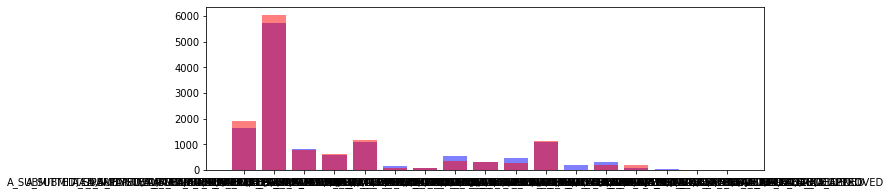

In [24]:
# debugging plots
pri = {k:v/100 for (k, v) in var_priv.items()}
plt.figure(figsize=(10,3))
plt.bar(*zip(*var_orig.items()), color='b', alpha=0.5)
plt.bar(*zip(*pri.items()), color='r', alpha=0.5)

In [478]:
# debugging plots
pri = {k:int(v/100) for (k, v) in var_priv.items()}
#plt.figure(figsize=(10,3))
#plt.bar(*zip(*var_orig.items()), color='b', alpha=0.5)
#plt.bar(*zip(*pri.items()), color='r', alpha=0.5)

In [479]:
# debugging abs log diff
log_diff(var_orig, pri)

21993

In [480]:
# debugging rel log sim
emd_utility(var_orig, pri)

0.7754333815209827

In [457]:
# save private logs
fp = open(f"logs/variants_gan_0.1_0.000001.json", "w")
json.dump(pri, fp)
fp.close()

In [ ]:
# DATA UTILITY RESULTS

        # 0.01      # 0.001     # 0.0001    # 0.00001   # 0.000001
# 2     0.73           0.72          0.69      0.71         0.72
# 1     0.73           0.73         0.68      0.74          0.69
# 0.1   0.59           0.58          0.56       0.54          0.55
# 0.01  0.54           -              -          -          -
# 0.001

In [77]:
# RESULT UTILITY RESULTS

        # 0.01      # 0.001     # 0.0001    # 0.00001   # 0.000001
# 2     20k          18k            23k        20k           21k
# 1     19k          24k           23k       27k           22k
# 0.1   17k          14k          11k        12k          13k     
# 0.01  13k          -            -           -           -
# 0.001